In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import time
from datetime import datetime
from timeit import default_timer as timer
from collections import Counter
from pathlib import Path

plt.rc('axes', labelsize=14)   # fontsize of the x and y labels
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=14)   # fontsize of the figure title
plt.rc('lines', markersize=7)
plt.rc('lines', linewidth=2)

In [2]:
datafolder = Path("C:\\Users\\Eliott\\Desktop\\ada\\ada-2021-project-quotebankers\\data")

DATA = {
    '2015': datafolder / Path("clean-quotes-2015.bz2"),
    '2016': datafolder / Path("clean-quotes-2016.bz2"),
    '2017': datafolder / Path("clean-quotes-2017.bz2"),
    '2018': datafolder / Path("clean-quotes-2018.bz2"),
    '2019': datafolder / Path("clean-quotes-2019.bz2"),
    '2020': datafolder / Path("clean-quotes-2020.bz2"),
}

ALL_YEARS = ["2015","2016","2017","2018","2019","2020"]

def load_data(year, sample=True, sample_size=100_000):
    if DATA[year].exists():
        if sample:
            df = pd.read_csv(DATA[year], compression='bz2', nrows=sample_size)
        else:
            df = pd.read_csv(DATA[year], compression='bz2')
        return df
    else:
        return None 
    
wikidata_speakers = pd.read_parquet('data\\speaker_attributes.parquet')
wikidata_speakers.set_index('id', inplace=True)

In [3]:
nrows = 10_000
df = load_data('2020', sample=True, sample_size=nrows)
if df is None:
    raise Exception('Failed to load dataset')
df.head()

,quotation,qids,date
0,[ Department of Homeland Security ] was livid ...,['Q367796'],2020-01-16 12:00:13
1,[ I met them ] when they just turned 4 and 7. ...,['Q20684375'],2020-01-24 20:37:09
2,[ The delay ] will have an impact [ on Slough ...,['Q5268447'],2020-01-17 13:03:00
3,[ The scheme ] treats addiction as an illness ...,['Q4864119'],2020-04-02 14:18:20
4,[ These ] actions will allow households who ha...,['Q816459'],2020-03-19 19:14:00


In [4]:
qids = df.qids.tolist()
wanted_qids = [eval(qid)[0] for qid in qids if len(eval(qid)) == 1 and eval(qid)[0] in wikidata_speakers.index]
speakers = wikidata_speakers.loc[wanted_qids]
speakers = speakers[~speakers.index.duplicated(keep='first')]

n_quotes_per_person = Counter(wanted_qids)
speakers['n_quotes'] = speakers.index.map(n_quotes_per_person)

ages = []
for date in speakers.date_of_birth.values:
    if not date is None:
        ages.append(datetime.now().year - int(date[0][1:5]))
    else:
        ages.append(None)

speakers['age'] = ages

In [5]:
speakers_features = speakers.drop(columns=['aliases', 'label', 'US_congress_bio_ID', 
                                           'lastrevid', 'type', 
                                           'candidacy', 'academic_degree', 
                                           'date_of_birth'])
speakers_features.head()

,nationality,gender,ethnic_group,occupation,party,religion,n_quotes,age
id,,,,,,,,
Q367796,[Q30],[Q6581072],None,[Q82955],[Q29468],[Q329646],1,80.0
Q20684375,None,[Q6581072],None,None,None,None,2,37.0
Q5268447,[Q23635],[Q6581097],None,[Q12299841],None,None,1,60.0
Q4864119,None,[Q6581097],None,None,[Q9630],None,1,NaN
Q816459,[Q30],[Q6581097],[Q49085],"[Q212980, Q9385011, Q82955, Q482980, Q1622272,...","[Q29468, Q29552, Q327591, Q29468]",[Q104319],1,70.0


In [23]:
speakers_features_preprocessed = pd.DataFrame()
speakers_features_preprocessed['n_quotes'] = speakers_features['n_quotes']
median_age = speakers_features['age'].median()
speakers_features_preprocessed['age'] = speakers_features['age'].fillna(median_age)

for name, values in speakers_features.iteritems():
    # Remove all None values from categorical rows, and keep only first instance of list occupation, nationality
    if name not in ['n_quotes', 'age']:
        updated_values = []
        for val in values:
            if not val is None:
                updated_values.append(val[0])
            else:
                updated_values.append('Unknown')
        speakers_features_preprocessed[name] = updated_values
    

speakers_features_preprocessed.head()

speakers_features_preprocessed.drop(columns=['ethnic_group', 'religion'])

,n_quotes,age,nationality,gender,occupation,party
id,,,,,,
Q367796,1,80.0,Q30,Q6581072,Q82955,Q29468
Q20684375,2,37.0,Unknown,Q6581072,Unknown,Unknown
Q5268447,1,60.0,Q23635,Q6581097,Q12299841,Unknown
Q4864119,1,52.0,Unknown,Q6581097,Unknown,Q9630
Q816459,1,70.0,Q30,Q6581097,Q212980,Q29468
...,...,...,...,...,...,...
Q5232225,1,43.0,Q30,Q6581097,Q28389,Unknown
Q17305692,1,24.0,Q30,Q6581072,Q44508716,Unknown
Q202342,1,79.0,Q408,Q6581072,Q10833314,Unknown


In [24]:
test = pd.get_dummies(speakers_features_preprocessed) # drop_first=True

In [25]:
test

,n_quotes,age,nationality_Q1006,nationality_Q1008,nationality_Q1009,nationality_Q1014,nationality_Q1028,nationality_Q1030,nationality_Q1033,nationality_Q1036,...,religion_Q9159,religion_Q922480,religion_Q9232,religion_Q9268,religion_Q9316,religion_Q93191,religion_Q9585,religion_Q9592,religion_Q9601,religion_Unknown
id,,,,,,,,,,,,,,,,,,,,,
Q367796,1,80.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q20684375,2,37.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Q5268447,1,60.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Q4864119,1,52.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Q816459,1,70.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q5232225,1,43.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Q17305692,1,24.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Q202342,1,79.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

  0%|          | 0/1 [00:00<?, ?it/s]

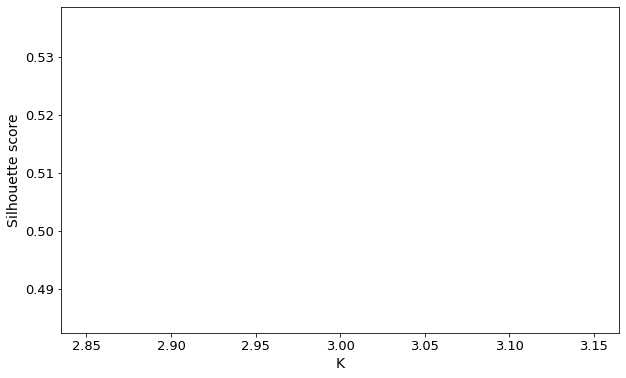

In [27]:
silhouettes = []

# Try multiple k
for k in tqdm(range(3, 4)):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(test)
    # Get the Silhouette score
    score = silhouette_score(test, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
# plt.xticks(range(2, 21), rotation=0)
plt.show()


In [29]:
# silhouettes.score
Counter(labels)

Counter({2: 2136, 0: 3303, 1: 2})

  0%|          | 0/50 [00:00<?, ?it/s]

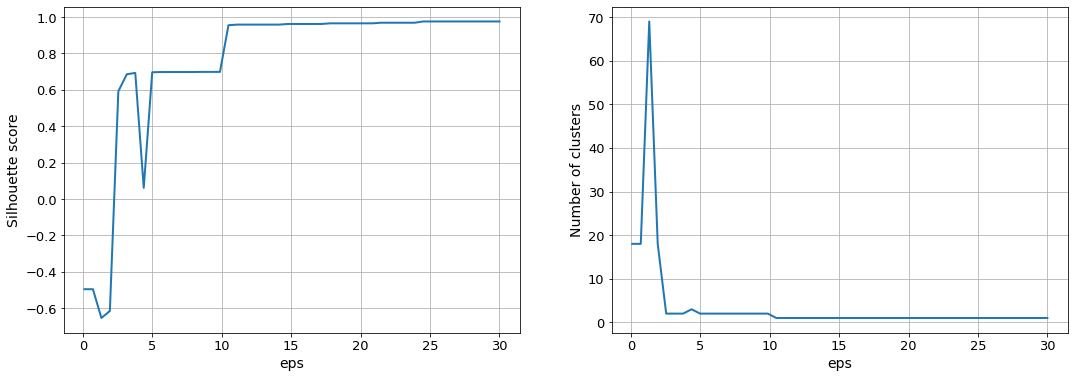

In [ ]:
silhouettes = []
n_labels = []
eps_list = np.linspace(0.1, 30, 50)

# Try multiple k
for k in tqdm(range(len(eps_list))):
    # Cluster the data and assigne the labels
    labels = DBSCAN(eps=eps_list[k]).fit_predict(test)
    n_labels.append(len(set(labels)) - (1 if -1 in labels else 0))
    # Get the Silhouette score
    score = silhouette_score(test, labels)
    silhouettes.append({"k": eps_list[k], "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("eps")
plt.ylabel("Silhouette score")
plt.grid()
#plt.xticks(range(2, 21), rotation=0)
plt.subplot(122)
plt.plot(silhouettes.k, n_labels)
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid()
plt.show()

In [ ]:
print(eps_list)
print(n_labels)
print(silhouettes.score)

[ 0.1         0.71020408  1.32040816  1.93061224  2.54081633  3.15102041
  3.76122449  4.37142857  4.98163265  5.59183673  6.20204082  6.8122449
  7.42244898  8.03265306  8.64285714  9.25306122  9.86326531 10.47346939
 11.08367347 11.69387755 12.30408163 12.91428571 13.5244898  14.13469388
 14.74489796 15.35510204 15.96530612 16.5755102  17.18571429 17.79591837
 18.40612245 19.01632653 19.62653061 20.23673469 20.84693878 21.45714286
 22.06734694 22.67755102 23.2877551  23.89795918 24.50816327 25.11836735
 25.72857143 26.33877551 26.94897959 27.55918367 28.16938776 28.77959184
 29.38979592 30.        ]
[18, 18, 69, 18, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
0     0.989969
1     0.510526
2     0.515804
3     0.534553
4     0.527579
5     0.513184
6     0.490007
7     0.482935
8     0.480924
9     0.476426
10    0.436166
11    0.442891
12    0.448200
13    0.422682
14    0.387890
15    0.411

  0%|          | 0/20 [00:00<?, ?it/s]

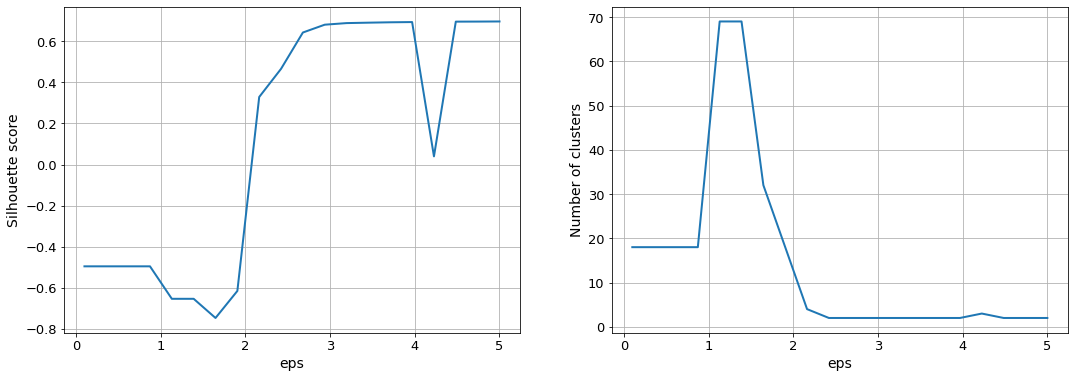

In [ ]:
silhouettes = []
n_labels = []
eps_list = np.linspace(0.1, 5, 20)

# Try multiple k
for k in tqdm(range(len(eps_list))):
    # Cluster the data and assigne the labels
    labels = DBSCAN(eps=eps_list[k]).fit_predict(test)
    n_labels.append(len(set(labels)) - (1 if -1 in labels else 0))
    # Get the Silhouette score
    score = silhouette_score(test, labels)
    silhouettes.append({"k": eps_list[k], "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("eps")
plt.ylabel("Silhouette score")
plt.grid()
#plt.xticks(range(2, 21), rotation=0)
plt.subplot(122)
plt.plot(silhouettes.k, n_labels)
plt.xlabel("eps")
plt.ylabel("Number of clusters")
plt.grid()
plt.show()

In [22]:
from collections import Counter
labels = DBSCAN(eps=1.9).fit_predict(test)
Counter(labels)

Counter({-1: 1434,
         0: 3862,
         1: 22,
         7: 5,
         9: 6,
         17: 4,
         11: 5,
         13: 5,
         2: 8,
         3: 22,
         4: 9,
         8: 15,
         12: 5,
         5: 6,
         10: 11,
         6: 6,
         14: 7,
         15: 4,
         16: 5})